# How to use the python Sparkplug extension for paho mqtt client in python
# _*HOST*_ Part (eg. the MES) run all cells and head over to node part
Example on how to use the python sparkplug mqtt extension togehter with the trial version of the Pro Edition of the Eclipse Mosquitto mqtt broker by cedalo

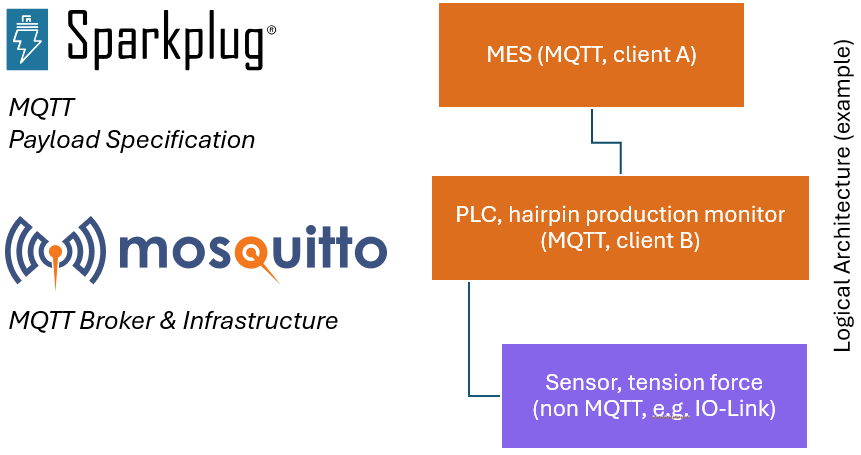

👉 [https://pypi.org/project/sparkplug/](https://pypi.org/project/sparkplug/)

👉 [Get the pro edition trial for eclipse mosquitto mqtt broker](https://cedalo.com/mqtt-broker-pro-mosquitto/)

👉 [Setup the client credentials](https://cedalo.com/blog/getting-started-pro-mosquitto-trial/)

## 1. Setup and Connect to MQTT broker via paho client
choose:
* protocol verion
* transport
* tls
* credentials

☝️ we need to hand over a (running) _paho_client_ object at the end.

In [ ]:
import paho.mqtt.client as paho_mqtt
from datetime import datetime as dt
from paho.mqtt.client import connack_string as ack
import ssl
import textwrap
import pysparkplug as psp
import json

### Sparkplug enabled System "SCADA/MES" (Host Application)
This client acts as a superordinary system for example in a industrial production. Refer to the image above.

In [ ]:
group_id = "production_line_PSM"
edge_node_id = "hairpin_production_monitor"
device_id = "tension_force"
sparkplug_host_id = "MYMES"

monitor_active = False # example value which will be set by commands

### MQTT Connection including WILL STATE (☝️)

In [ ]:
version = '5' # '5' or '3'
mytransport = 'tcp' # 'websocket' or 'tcp'
broker = 'mqtt.jhub.svc' # eg. choosen-name-xxxx.cedalo.cloud --> get it from cedalo
myport = 1883
user = "client"
password = "fhws4eveR!"
tls = False

#----------- No need to edit below except cert based authentication is needed
if version == '5':
    paho_client = paho_mqtt.Client(client_id="Host",
                         transport=mytransport,
                         protocol=paho_mqtt.MQTTv5)
if version == '3':
    paho_client = paho_mqtt.Client(client_id="Host",
                         transport=mytransport,
                         protocol=paho_mqtt.MQTTv311,
                         clean_session=True)

paho_client.username_pw_set(user,password)
if tls:
    paho_client.tls_set(
        certfile=None,
        keyfile=None,
        # If these arguments above are not None then they will
        # be used as client information for TLS based
        # authentication and authorization (depends on broker setup).
        cert_reqs=ssl.CERT_REQUIRED)
        # this makes it mandatory that the broker
        # has a valid certificate

def paho_on_connect(client, userdata, flags, rc, v5config=None):
    print(dt.now().strftime("%H:%M:%S.%f")[:-2] + " HOST connection returned result: "+ack(rc))

paho_client.on_connect = paho_on_connect;

# Register a WILL message see Spec: 12.63. STATE
paho_client.will_set("spBv1.0/STATE/"+sparkplug_host_id,
                     json.dumps({'online':False,'timestamp':psp.get_current_timestamp()}),
                     1, True)

if version == '5':
    from paho.mqtt.properties import Properties
    from paho.mqtt.packettypes import PacketTypes 
    properties=Properties(PacketTypes.CONNECT)
    properties.SessionExpiryInterval=0 # as claimed by Sparkplug definition
    paho_client.connect(broker,
                   port=myport,
                   clean_start=paho_mqtt.MQTT_CLEAN_START_FIRST_ONLY,
                   properties=properties,
                   keepalive=60);

if version == '3':
    paho_client.connect(broker,port=myport);

paho_client.loop_start();
paho_client.subscribe("spBv1.0/STATE/"+sparkplug_host_id,1)

## Sparkplug: Set Host Application Online

In [ ]:
mes_client = psp.Client()

mes_client._client = paho_client

mes_cmd_topic = psp.Topic(
    message_type=psp.MessageType.STATE,
    group_id=group_id,
    sparkplug_host_id=sparkplug_host_id
)

mes_cmd_payload = psp.State(
    timestamp=psp.get_current_timestamp(),
    online=True
)

mes_cmds = psp.Message(
    topic=mes_cmd_topic,
    payload=mes_cmd_payload,
    qos=psp.QoS.AT_MOST_ONCE,
    retain=True
)

mes_client.publish(
    mes_cmds,
    include_dtypes=True
)

### Demo Functionality of Host Applicatoin: Control the monitoring activity via the MES aka. send commands to node

In [ ]:
# example logic subscribe on Data amd Cmd messages
def callback(client: psp.Client, message: psp.Message) -> None:
    # Device Data only
    if isinstance(message.payload, (psp.DData)):
        for metric in message.payload.metrics:
            print("DData ", metric.name)
            print(textwrap.indent(str(metric.value), "  "))
        return
    # Command
    if isinstance(message.payload,(psp.NCmd,)):
        if message.topic.group_id == group_id:
            for metric in message.payload.metrics:
                print("NCmd ", metric.name, metric.value)
            return

# Example, subscribe to all topics for demonstration and bind to the defined callback
mes_client.subscribe(psp.Topic("#"), psp.QoS.AT_LEAST_ONCE, callback)            

### Now turn on/off and see the results

In [ ]:
# toggle
monitor_active = not monitor_active 

mes_cmd_metric = ( # Value false || true
    psp.Metric(timestamp=psp.get_current_timestamp(), name="process_monitor_active", datatype=psp.DataType.BOOLEAN, value=monitor_active),
)
# set message and publish
mes_cmd_topic = psp.Topic(message_type=psp.MessageType.NCMD,group_id=group_id,edge_node_id=edge_node_id)
mes_cmd_payload = psp.DCmd(timestamp=psp.get_current_timestamp(), metrics=mes_cmd_metric)
mes_cmds = psp.Message(topic=mes_cmd_topic,payload=mes_cmd_payload, qos=psp.QoS.AT_MOST_ONCE, retain=False)
mes_client.publish(mes_cmds,include_dtypes=True)